在代码中增加随机剪裁等，增加数据量

In [71]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import h5py
from matplotlib import pyplot as plt
from IPython import display
from matplotlib_inline import backend_inline
from torchvision.transforms import functional as F

import torch.nn.functional as F1 
## 定义动态曲线类
from animator import Animator, use_svg_display, set_axes

# 定义所需要的函数


## 可视化数据增强前后的函数

In [72]:
def visualize_augmentation(original, augmented):
    # 将数据转换为numpy格式以便matplotlib绘图
    original_np = original.squeeze().numpy()
    augmented_np = augmented.squeeze().numpy()
    
    # 画出原始和增强后的图像
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(original_np[0], cmap='RdBu_r')  # 显示第一个通道的数据
    axs[0].set_title("Original")
    axs[1].imshow(augmented_np[0], cmap='RdBu_r')  # 显示第一个通道的数据
    axs[1].set_title("Augmented")
    plt.show()

In [73]:
# 设定设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [74]:
# 文件路径
file_path = r'D:\\zjPhD\\turbulenceData\\turbulenceData\\isotropic1024coarse_10.h5'
validation_file_path = r'D:\\zjPhD\\turbulenceData\\turbulenceData\\isotropic1024coarse_test.h5'


In [75]:

import torchvision
from torchvision.transforms.functional import resize

def downsample(data, size=64):
    """
    使用双三次插值将数据降采样到指定尺寸。
    假设输入数据是2D numpy数组，返回同样类型的数据。
    """
    data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # 添加batch和channel维度
    data_resized = resize(data_tensor, (size, size), interpolation=torchvision.transforms.InterpolationMode.BICUBIC)
    return data_resized.squeeze().numpy()  # 去掉batch和channel维度，并转换回numpy


In [76]:
"""
旋转（Rotation）：

随机旋转一个角度，范围在 -30 度到 30 度之间。代码中使用 F.rotate 实现。
水平翻转（Horizontal Flip）：

以50%的概率对图像进行水平翻转。代码中使用 F.hflip 实现。
垂直翻转（Vertical Flip）：

以50%的概率对图像进行垂直翻转。代码中使用 F.vflip 实现。
随机中心裁剪（Random Center Crop）：

随机选择一个大小（从图像的一半到原始大小之间），然后从中心裁剪图像。代码中使用 F.center_crop 实现。
"""
def augment_data(tensor):
    """对输入的张量进行数据增强."""
    angle = np.random.uniform(-30, 30)
    tensor = F.rotate(tensor, angle)

    if np.random.rand() > 0.5:
        tensor = F.hflip(tensor)

    if np.random.rand() > 0.5:
        tensor = F.vflip(tensor)

    size = tensor.size(-1)
    crop_size = np.random.randint(size//2, size)
    tensor = F.center_crop(tensor, [crop_size, crop_size])
    tensor = F.resize(tensor, [size, size])

    return tensor


In [77]:
num_augmentations = 5
all_velocity_fields = []

In [78]:
with h5py.File(file_path, 'r') as f:
    velocity_datasets = [name for name in f.keys() if 'Velocity' in name]
    for dataset_name in velocity_datasets:
        data = f[dataset_name][()]
        U_x = data[0, :, :, 0]
        U_y = data[0, :, :, 1]
        U_magnitude = data[0, :, :, 2]

        U_x_downsampled = downsample(U_x)
        U_y_downsampled = downsample(U_y)
        U_magnitude_downsampled = downsample(U_magnitude)

        U_x_tensor = torch.tensor(U_x_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        U_y_tensor = torch.tensor(U_y_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        U_magnitude_tensor = torch.tensor(U_magnitude_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        velocity_field = torch.cat((U_x_tensor, U_y_tensor, U_magnitude_tensor), dim=1)
        for _ in range(num_augmentations):
            augmented_velocity_field = augment_data(velocity_field.clone())
            all_velocity_fields.append(augmented_velocity_field)


In [79]:
# 将列表转换为 tensor
# all_velocity_fields = torch.stack(all_velocity_fields).to(device)


In [80]:
# print(U_x.shape)
# print(U_x_downsampled.shape)
# print(U_x_tensor.shape)
# print(velocity_field.shape)
# print(len(all_velocity_fields))

In [81]:
# len(all_velocity_fields)

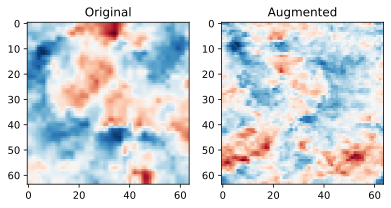

In [99]:
# # 调用函数进行可视化————可视化增强数据的前后情况。
visualize_augmentation(augmented_velocity_field, velocity_field)

In [83]:
# 定义自定义数据集类
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, velocity_fields):
        self.velocity_fields = velocity_fields

    def __len__(self):
        return len(self.velocity_fields)

    def __getitem__(self, idx):
        sample = self.velocity_fields[idx]
        sample = augment_data(sample.clone())  # 动态应用数据增强
        return sample

In [84]:
# 合并所有增强后的数据
all_velocity_fields = torch.cat(all_velocity_fields, dim=0).to(device)
num_samples = all_velocity_fields.shape[0]
size_low = all_velocity_fields.shape[2]
target_abcd = torch.zeros((num_samples, 4, size_low, size_low), dtype=torch.float32).to(device)


# 创建数据集和数据加载器
dataset = TensorDataset(all_velocity_fields, target_abcd)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [85]:
all_velocity_fields.shape

torch.Size([100, 3, 64, 64])

In [86]:
# 读取验证数据集并降采样
with h5py.File(validation_file_path, 'r') as f:
    velocity_datasets = [name for name in f.keys() if 'Velocity' in name]
    all_validation_velocity_fields = []
    
    for dataset_name in velocity_datasets:
        data = f[dataset_name][()]
        U_x = data[0, :, :, 0]
        U_y = data[0, :, :, 1]
        U_magnitude = data[0, :, :, 2]
        
        U_x_downsampled = downsample(U_x)
        U_y_downsampled = downsample(U_y)
        U_magnitude_downsampled = downsample(U_magnitude)
        
        U_x_tensor = torch.tensor(U_x_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        U_y_tensor = torch.tensor(U_y_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        U_magnitude_tensor = torch.tensor(U_magnitude_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        
        velocity_field = torch.cat((U_x_tensor, U_y_tensor, U_magnitude_tensor), dim=1)
        all_validation_velocity_fields.append(velocity_field)
    
    all_validation_velocity_fields = torch.cat(all_validation_velocity_fields, dim=0).to(device)
    num_samples_val = all_validation_velocity_fields.shape[0]
    target_abcd_val = torch.zeros((num_samples_val, 4, size_low, size_low), dtype=torch.float32).to(device)
    
    validation_dataset = TensorDataset(all_validation_velocity_fields, target_abcd_val)
    validation_dataloader = DataLoader(validation_dataset, batch_size=2, shuffle=False)


In [87]:
#可以查看数据范围，xyz都是（0，$2\pi$）
size_low = 64

dx = 2*np.pi/size_low
dy = 2*np.pi/size_low
dz = 2*np.pi/size_low

In [88]:
class ComplexModelA(nn.Module):
    def __init__(self):
        super(ComplexModelA, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn9 = nn.BatchNorm2d(64)
        
        self.conv10 = nn.Conv2d(64, 4, kernel_size=3, padding=1)
        
    def forward(self, x):
        # Encoder
        x1 = F1.relu(self.bn1(self.conv1(x)))
        x2 = self.pool(x1)
        x2 = F1.relu(self.bn2(self.conv2(x2)))
        x3 = self.pool(x2)
        x3 = F1.relu(self.bn3(self.conv3(x3)))
        x4 = self.pool(x3)
        x4 = F1.relu(self.bn4(self.conv4(x4)))
        x5 = self.pool(x4)
        x5 = F1.relu(self.bn5(self.conv5(x5)))
        
        # Decoder
        x = self.upconv1(x5)
        x = torch.cat((x, x4), dim=1)  # Skip connection
        x = F1.relu(self.bn6(self.conv6(x)))
        
        x = self.upconv2(x)
        x = torch.cat((x, x3), dim=1)  # Skip connection
        x = F1.relu(self.bn7(self.conv7(x)))
        
        x = self.upconv3(x)
        x = torch.cat((x, x2), dim=1)  # Skip connection
        x = F1.relu(self.bn8(self.conv8(x)))
        
        x = self.upconv4(x)
        x = torch.cat((x, x1), dim=1)  # Skip connection
        x = F1.relu(self.bn9(self.conv9(x)))
        
        x = self.conv10(x)
        return x

# 定义损失函数和辅助函数

In [89]:
def calculate_gradients_with_numpy(tensor):
    tensor_np = tensor.detach().cpu().numpy()
    grad_x = np.gradient(tensor_np, axis=1)
    grad_y = np.gradient(tensor_np, axis=2)
    grad_x_tensor = torch.from_numpy(grad_x).to(tensor.device)
    grad_y_tensor = torch.from_numpy(grad_y).to(tensor.device)
    return grad_x_tensor, grad_y_tensor

def laplacian_2d_torch(tensor, dx, dy):
    tensor = tensor.float()
    tensor_np = tensor.detach().cpu().numpy()
    grad_x = np.gradient(tensor_np, axis=1)
    grad_y = np.gradient(tensor_np, axis=2)
    laplacian_x = np.gradient(grad_x, axis=1)
    laplacian_y = np.gradient(grad_y, axis=2)
    laplacian_x_tensor = torch.from_numpy(laplacian_x).to(tensor.device)
    laplacian_y_tensor = torch.from_numpy(laplacian_y).to(tensor.device)
    laplacian = laplacian_x_tensor + laplacian_y_tensor
    return laplacian

def loss_function(predicted_abcd, true_velocity, model, epsilon, l1_lambda=0.0, l2_lambda=0.0):
    predicted_abcd = predicted_abcd.to(device)
    true_velocity = true_velocity.to(device)
    
    a = predicted_abcd[:, 0, :, :]
    b = predicted_abcd[:, 1, :, :]
    c = predicted_abcd[:, 2, :, :]
    d = predicted_abcd[:, 3, :, :]
    
    a_grad_x, a_grad_y = calculate_gradients_with_numpy(a)
    b_grad_x, b_grad_y = calculate_gradients_with_numpy(b)
    c_grad_x, c_grad_y = calculate_gradients_with_numpy(c)
    d_grad_x, d_grad_y = calculate_gradients_with_numpy(d)

    hbar = 1

    U_x_pred = a + b
    U_y_pred = c + d
    U_magnitude_pred = torch.sqrt(U_x_pred**2 + U_y_pred**2)
    
    U_x_true = true_velocity[:, 0, :, :]
    U_y_true = true_velocity[:, 1, :, :]
    U_magnitude_true = true_velocity[:, 2, :, :]

    loss_velocity = F1.mse_loss(U_magnitude_pred, U_magnitude_true) + F1.mse_loss(U_x_pred, U_x_true) + F1.mse_loss(U_y_pred, U_y_true)
    
    norm = a**2 + b**2 + c**2 + d**2
    norm_constraint = F1.mse_loss(norm, torch.ones_like(norm))
    
    lap_b = laplacian_2d_torch(b, dx, dx)
    lap_a = laplacian_2d_torch(a, dx, dx)
    lap_d = laplacian_2d_torch(d, dx, dx)
    lap_c = laplacian_2d_torch(c, dx, dx)

    curl_constraint = (a * lap_b - b * lap_a + c * lap_d - d * lap_c).sum()
    
    l1_regularization = torch.tensor(0., requires_grad=True).to(device)
    if l1_lambda > 0:
        l1_regularization = sum(torch.sum(torch.abs(param)) for param in model.parameters())

    l2_regularization = torch.tensor(0., requires_grad=True).to(device)
    if l2_lambda > 0:
        l2_regularization = sum(torch.sum(param**2) for param in model.parameters())
    
    regularization_term = epsilon * 0.25 * (torch.sum(a**2) + torch.sum(b**2) + torch.sum(c**2) + torch.sum(d**2))
    
    total_loss = loss_velocity + l1_lambda * l1_regularization + l2_lambda * l2_regularization # + norm_constraint + curl_constraint + regularization_term 
    return total_loss

In [90]:
# 设置训练和验证参数
learning_rate = 0.001
num_epochs = 5000
epsilon = 0.01
l1_lambda = 0.001
l2_lambda = 0.001

In [91]:
# 创建模型和优化器
model = ComplexModelA().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

KeyboardInterrupt: 

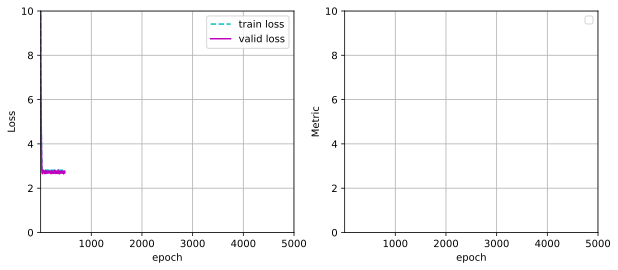

In [92]:
# 设置动画器
animator = Animator(
    xlabels=["epoch", "epoch"],
    ylabels=["Loss", "Metric"],
    legends=[["train loss", "valid loss"], ["train metric", "valid metric"]],
    xlims=[[1, num_epochs], [1, num_epochs]],
    ylims=[[0, 10], [0, 10]]
)

# 训练和验证
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i, (velocity, _) in enumerate(dataloader):
        velocity = velocity.to(device)
        optimizer.zero_grad()
        predicted_abcd = model(velocity)
        loss = loss_function(predicted_abcd, velocity, model, epsilon, l1_lambda, l2_lambda)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(dataloader)
    
    # 验证
    # model.eval()
    validation_loss = 0
    with torch.no_grad():
            
        for val_velocity, _ in validation_dataloader:
            val_velocity = val_velocity.to(device)
            val_predicted_abcd = model(val_velocity)
            val_loss = loss_function(val_predicted_abcd, val_velocity, model, epsilon, l1_lambda, l2_lambda)
            validation_loss += val_loss.item()
    validation_loss /= len(validation_dataloader)


    # 动态更新绘图
    animator.add(epoch + 1, (epoch_loss, validation_loss))

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {validation_loss:.4f}')


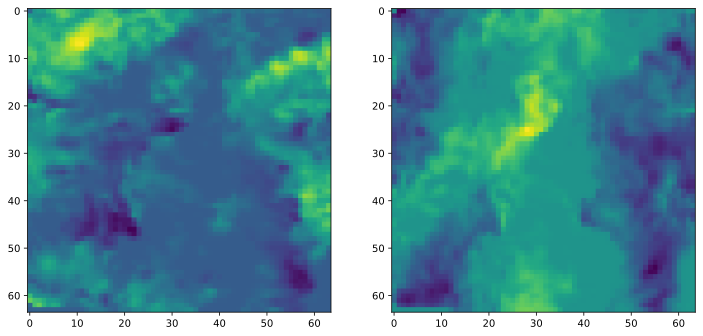

In [93]:
# 预测和结果展示
predicted_abcd = model(all_velocity_fields)
predicted_abcd = predicted_abcd.detach().cpu().numpy()
a_pre = predicted_abcd[1, 0, :, :]
b_pre = predicted_abcd[1, 1, :, :]
c_pre = predicted_abcd[1, 2, :, :]
d_pre = predicted_abcd[1, 3, :, :]

a_test_grad_x, a_test_grad_y = np.gradient(a_pre, dx)
b_test_grad_x, b_test_grad_y = np.gradient(b_pre, dx)
c_test_grad_x, c_test_grad_y = np.gradient(c_pre, dx)
d_test_grad_x, d_test_grad_y = np.gradient(d_pre, dx)

U_x_pred_test = a_pre + b_pre
U_y_pred_test = c_pre + d_pre
U_magnitude_pred_test = np.sqrt(U_x_pred_test**2 + U_y_pred_test**2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(U_x_pred_test, cmap='viridis')
plt.subplot(1, 2, 2)
plt.imshow(U_y_pred_test, cmap='viridis')


In [94]:
def vorticity(U_x, U_y, dx, dy):
    dU_y_dx, _ = np.gradient(U_y, dx, axis=0), np.gradient(U_y, dy, axis=1)
    _, dU_x_dy = np.gradient(U_x, dx, axis=0), np.gradient(U_x, dy, axis=1)
    return dU_y_dx - dU_x_dy


# 计算归一化的涡度
def vorticity_normalize(vorticity):
    max_vorticity = np.max(np.abs(vorticity))
    vort_normalized = vorticity / max_vorticity if max_vorticity != 0 else vorticity
    return vort_normalized

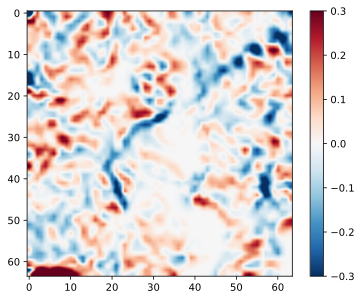

In [95]:
vort_pre = vorticity(U_x_pred_test, U_y_pred_test, dx, dx)

vorticity_normalized_pre = vorticity_normalize(vort_pre)

plt.imshow(vorticity_normalized_pre, cmap='RdBu_r',vmin=-0.3,vmax=0.3,interpolation='bilinear')
plt.colorbar()

In [96]:
# 预测和结果展示
model.eval()
predicted_abcd = model(all_velocity_fields)
predicted_abcd = predicted_abcd.detach().cpu().numpy()

In [97]:
all_validation_velocity_fields.shape,validation_sample.shape

(torch.Size([1, 3, 64, 64]), (3, 64, 64))

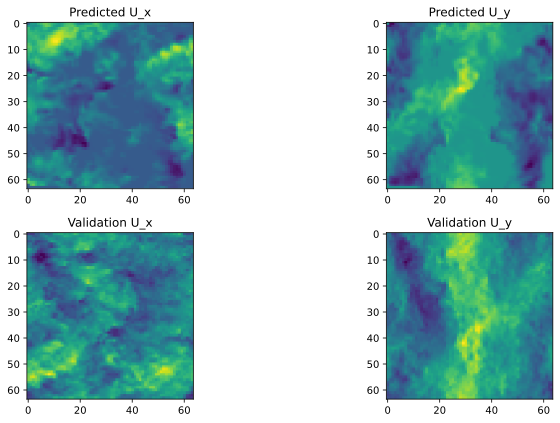

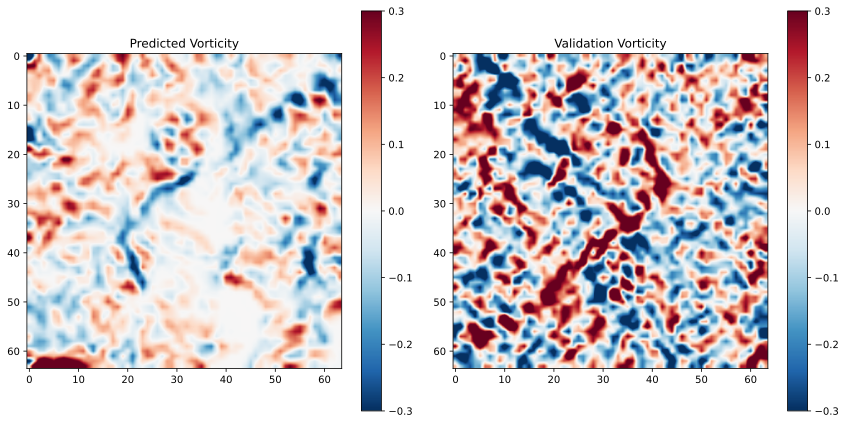

In [98]:

# 获取验证数据的一个示例进行对比
validation_sample = all_validation_velocity_fields[0].detach().cpu().numpy()

# 计算预测的 U_x, U_y 和 U_magnitude
a_pre = predicted_abcd[1, 0, :, :]
b_pre = predicted_abcd[1, 1, :, :]
c_pre = predicted_abcd[1, 2, :, :]
d_pre = predicted_abcd[1, 3, :, :]

U_x_pred_test = a_pre + b_pre
U_y_pred_test = c_pre + d_pre
U_magnitude_pred_test = np.sqrt(U_x_pred_test**2 + U_y_pred_test**2)

# 计算验证数据的 U_x, U_y 和 U_magnitude
U_x_val_test = validation_sample[ 0, :, :]
U_y_val_test = validation_sample[ 1, :, :]
U_magnitude_val_test = validation_sample[ 2, :, :]

# 显示预测和验证的 U_x, U_y
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.imshow(U_x_pred_test, cmap='viridis')
plt.title('Predicted U_x')
plt.subplot(2, 2, 2)
plt.imshow(U_y_pred_test, cmap='viridis')
plt.title('Predicted U_y')

plt.subplot(2, 2, 3)
plt.imshow(U_x_val_test, cmap='viridis')
plt.title('Validation U_x')
plt.subplot(2, 2, 4)
plt.imshow(U_y_val_test, cmap='viridis')
plt.title('Validation U_y')

plt.tight_layout()
plt.show()

# 计算和显示归一化的涡度
def vorticity(U_x, U_y, dx, dy):
    dU_y_dx, _ = np.gradient(U_y, dx, axis=0), np.gradient(U_y, dy, axis=1)
    _, dU_x_dy = np.gradient(U_x, dx, axis=0), np.gradient(U_x, dy, axis=1)
    return dU_y_dx - dU_x_dy

def vorticity_normalize(vorticity):
    max_vorticity = np.max(np.abs(vorticity))
    vort_normalized = vorticity / max_vorticity if max_vorticity != 0 else vorticity
    return vort_normalized

vort_pre = vorticity(U_x_pred_test, U_y_pred_test, dx, dx)
vorticity_normalized_pre = vorticity_normalize(vort_pre)

vort_val = vorticity(U_x_val_test, U_y_val_test, dx, dx)
vorticity_normalized_val = vorticity_normalize(vort_val)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(vorticity_normalized_pre, cmap='RdBu_r', vmin=-0.3, vmax=0.3, interpolation='bilinear')
plt.title('Predicted Vorticity')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(vorticity_normalized_val, cmap='RdBu_r', vmin=-0.3, vmax=0.3, interpolation='bilinear')
plt.title('Validation Vorticity')
plt.colorbar()

plt.tight_layout()
plt.show()